<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/POLLARDSTOWN_s_w_3_DSM_INDICES_slope_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#unzip
!unzip -q "/content/drive/MyDrive/Pollardstown.zip" -d "/content/dataset"

replace /content/dataset/Pollardstown/habitat info.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.qmd? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_clappied.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/pollardstown_dem.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/pollardstown_ortho.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif? [y]

In [19]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [20]:
S_RGB_PATH = '/content/dataset/Pollardstown/pollardstown_ortho.tif'
S_NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif'

W_RGB_PATH = '/content/dataset/Pollardstown/Pollardstown_Winter_RGB.tif'
W_NDVI_PATH = '/content/dataset/Pollardstown/Pollardstown_Winter_NDVI.tif'

SHP_PATH = '/content/dataset/Pollardstown/Pollardstown_clappied.shp'

In [21]:
LABEL_COL = 'Id'
NAME_COL = 'PRIMARY_FO'

gdf = gpd.read_file(SHP_PATH)

In [26]:
fossitt_merger = {
    'WN6': 'Woodland_Scrub', 'WL2': 'Woodland_Scrub', 'WS1/WL2': 'Woodland_Scrub',
    'WN6/FS1': 'Woodland_Scrub', 'GS4/WS1': 'Woodland_Scrub', 'Scrub_Woodland': 'Woodland_Scrub',
    'GA1': 'Grassland_Improved', 'GS4': 'Grassland_Wet',
    'PF1': 'Wetland_Peatland', 'FS1': 'Wetland_Peatland', 'FS1/FS2': 'Wetland_Peatland',
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland', 'GS4/FS2': 'Wetland_Peatland'
}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [27]:
all_pixels, all_labels = [], []

# --- 2. COORDINATED EXTRACTION ---
# Open all 4 sources
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['PRIMARY_FO'].replace(fossitt_merger)

    print("Extracting 11 seasonal features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 300: break

            if not points: continue

            # Sample all 4 rasters
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')
            w_rgb_vals = np.array(list(wr.sample(points))).astype('float32')
            w_ndvi_vals = np.array(list(wn.sample(points))).astype('float32')

            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)
            w_vari = (w_rgb_vals[:,1]-w_rgb_vals[:,0]) / (w_rgb_vals[:,1]+w_rgb_vals[:,0]-w_rgb_vals[:,2]+1e-5)
            # 11: Delta NDVI (Seasonality change)
            delta_ndvi = s_ndvi_vals - w_ndvi_vals

            combined = np.column_stack([
                s_rgb_vals, w_rgb_vals,
                s_ndvi_vals, w_ndvi_vals,
                s_vari, w_vari,
                delta_ndvi
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting 11 seasonal features...


In [28]:
print(f"Total training samples: {len(X)}")

Total training samples: 8316


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))


--- Final Multi-Source Seasonal Report ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.63      0.49      0.55       536
Wetland_Peatland       0.84      0.92      0.88      1525
  Woodland_Scrub       0.66      0.60      0.63       434

        accuracy                           0.77      2495
       macro avg       0.71      0.67      0.69      2495
    weighted avg       0.76      0.77      0.76      2495



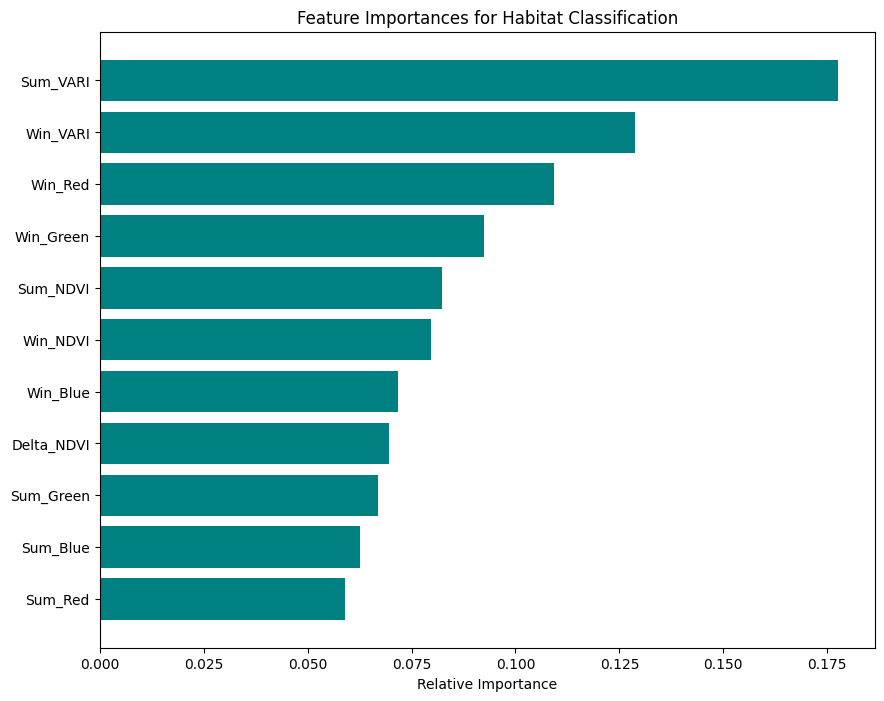

In [30]:
from matplotlib import pyplot as plt
# Create a list of names matching your 'combined' array columns
feature_names = [
    'Sum_Red', 'Sum_Green', 'Sum_Blue',
    'Win_Red', 'Win_Green', 'Win_Blue',
    'Sum_NDVI', 'Win_NDVI',
    'Sum_VARI', 'Win_VARI',
    'Delta_NDVI'
]

# Get importances from the trained RF
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances for Habitat Classification')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

dsm

In [31]:
import numpy as np
from scipy import ndimage

In [32]:
S_DSM = '/content/dataset/Pollardstown/pollardstown_dem.tif'
W_DSM = '/content/dataset/Pollardstown/Pollardstown_Winter_DSM.tif'

In [33]:
fossitt_merger = {
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland',
    'GS4/WS1': 'Woodland_Scrub', 'WN6/FS1': 'Woodland_Scrub',
    'Grassland_Wet': 'Grassland_Wet', 'Wetland_Peatland': 'Wetland_Peatland',
    'Woodland_Scrub': 'Woodland_Scrub'
}

In [34]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

In [35]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['PRIMARY_FO'].replace(fossitt_merger)

    print("Extracting 14 Seasonal + Height features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 100)
        if not pts: continue

        # Sample all 6 rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # Combine into 14-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h)            # 14: Delta Height
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 14 Seasonal + Height features...
Final Data Sync: X=(2700, 14), y=(2700,)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [37]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [38]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 14-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 14-FEATURE REPORT ---
                  precision    recall  f1-score   support

             FS1       0.69      0.36      0.47       102
             GS4       0.60      0.61      0.61       173
             PF1       0.65      0.88      0.75       312
             WL2       0.33      0.11      0.17         9
             WN6       0.57      0.51      0.54        45
         WS1/WL2       0.40      0.14      0.21        28
Wetland_Peatland       0.63      0.42      0.50        81
  Woodland_Scrub       0.50      0.45      0.47        60

        accuracy                           0.62       810
       macro avg       0.55      0.44      0.47       810
    weighted avg       0.62      0.62      0.60       810



In [39]:
final_clean_map = {
    'FS1': 'Wetland_Peatland',
    'PF1': 'Wetland_Peatland',
    'Wetland_Peatland': 'Wetland_Peatland',
    'GS4': 'Grassland_Wet',
    'WN6': 'Woodland_Scrub',
    'WL2': 'Woodland_Scrub',
    'WS1/WL2': 'Woodland_Scrub',
    'Woodland_Scrub': 'Woodland_Scrub'
}

# Apply to your current y array
y_final_cleaned = np.array([final_clean_map.get(label, 'Other') for label in y])

# Filter out 'Other' if any exist
mask = y_final_cleaned != 'Other'
X_clean = X[mask]
y_clean = y_final_cleaned[mask]

# Re-split and Re-train
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, stratify=y_clean, random_state=42
)

rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- CLEANED 14-FEATURE REPORT ---")
print(classification_report(y_test, rf.predict(X_test)))


--- CLEANED 14-FEATURE REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.67      0.54      0.60       173
Wetland_Peatland       0.87      0.95      0.91       495
  Woodland_Scrub       0.71      0.68      0.69       142

        accuracy                           0.81       810
       macro avg       0.75      0.72      0.73       810
    weighted avg       0.80      0.81      0.80       810



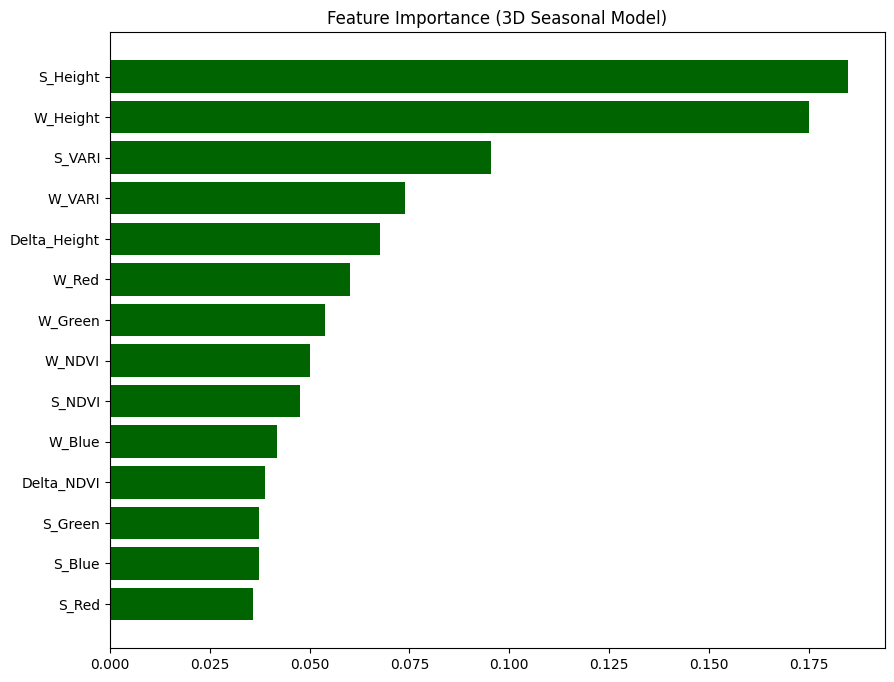

In [40]:
importances = rf.feature_importances_
feature_names = [
    'S_Red', 'S_Green', 'S_Blue', 'W_Red', 'W_Green', 'W_Blue',
    'S_NDVI', 'W_NDVI', 'S_VARI', 'W_VARI', 'Delta_NDVI',
    'S_Height', 'W_Height', 'Delta_Height'
]
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance (3D Seasonal Model)')
plt.barh(range(len(indices)), importances[indices], color='darkgreen', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

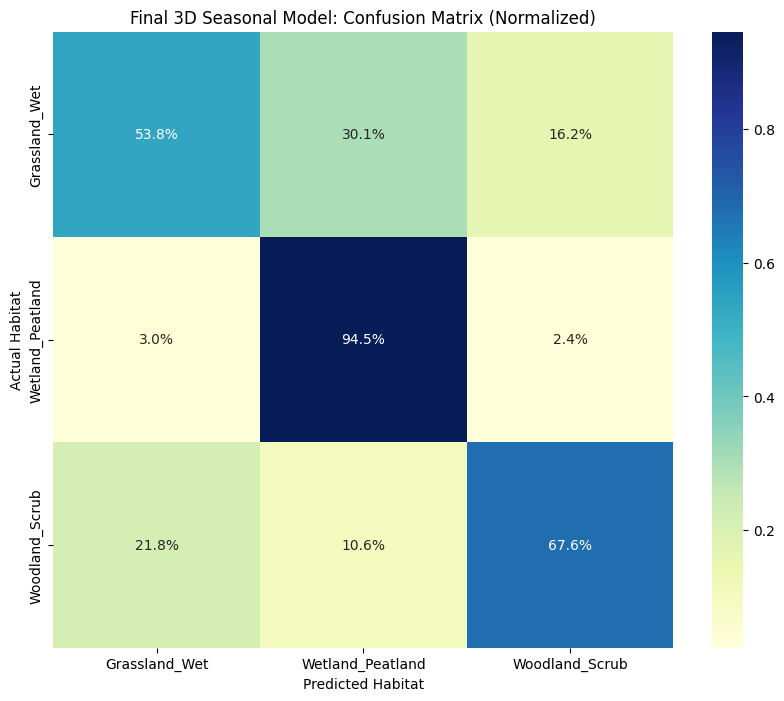

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

In [42]:
fossitt_merger = {
    'FS1/PF1': 'Wetland_Peatland', 'GS4/FS1': 'Wetland_Peatland',
    'GS4/WS1': 'Woodland_Scrub', 'WN6/FS1': 'Woodland_Scrub',
    'Grassland_Wet': 'Grassland_Wet', 'Wetland_Peatland': 'Wetland_Peatland',
    'Woodland_Scrub': 'Woodland_Scrub'
}

In [43]:
#slope
def calculate_local_slope(window, res=1.0):
    """Calculates slope in degrees from a 3x3 elevation window."""
    # Horn's method for slope
    dz_dx = ((window[0,2] + 2*window[1,2] + window[2,2]) -
             (window[0,0] + 2*window[1,0] + window[2,0])) / (8 * res)
    dz_dy = ((window[2,0] + 2*window[2,1] + window[2,2]) -
             (window[0,0] + 2*window[0,1] + window[0,2])) / (8 * res)

    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

In [44]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0] # Get resolution for slope calc (likely 1.0 or 0.5)
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['PRIMARY_FO'].replace(fossitt_merger)

    print("Extracting 16 Features (Seasonal + Height + Slope)...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 500)
        if not pts: continue

        # Standard sampling
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # Slope Sampling (requires reading a small window around each point)
        s_slopes, w_slopes = [], []
        for pt in pts:
            # Get pixel coordinates for the DSMs
            row_idx, col_idx = sd.index(pt[0], pt[1])
            # Read 3x3 window
            win = rasterio.windows.Window(col_idx - 1, row_idx - 1, 3, 3)

            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            w_win = wd.read(1, window=win, boundless=True, fill_value=0)

            s_slopes.append(calculate_local_slope(s_win, RES))
            w_slopes.append(calculate_local_slope(w_win, RES))

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)
        w_vari = (w_rgb[:,1]-w_rgb[:,0]) / (w_rgb[:,1]+w_rgb[:,0]-w_rgb[:,2]+1e-5)

        # 16-column stack
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_vari, w_vari,        # 9-10
            (s_nd - w_nd),         # 11: Delta NDVI
            s_h, w_h,              # 12-13
            (s_h - w_h),           # 14: Delta Height
            s_slopes, w_slopes     # 15-16: Slope layers
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Extraction Complete: X={X.shape}")

Extracting 16 Features (Seasonal + Height + Slope)...
Extraction Complete: X=(13570, 16)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [46]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [47]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 16-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 16-FEATURE REPORT ---
                  precision    recall  f1-score   support

             FS1       0.72      0.46      0.56       511
             GA1       1.00      1.00      1.00         1
             GS4       0.66      0.64      0.65       866
             PF1       0.70      0.87      0.78      1571
             WL2       0.25      0.10      0.15        39
             WN6       0.60      0.64      0.62       232
         WS1/WL2       0.49      0.28      0.36       145
Wetland_Peatland       0.62      0.52      0.57       406
  Woodland_Scrub       0.59      0.50      0.54       300

        accuracy                           0.67      4071
       macro avg       0.62      0.56      0.58      4071
    weighted avg       0.66      0.67      0.65      4071



In [48]:
final_clean_map = {
    'FS1': 'Wetland_Peatland',
    'PF1': 'Wetland_Peatland',
    'Wetland_Peatland': 'Wetland_Peatland',
    'GS4': 'Grassland_Wet',
    'WN6': 'Woodland_Scrub',
    'WL2': 'Woodland_Scrub',
    'WS1/WL2': 'Woodland_Scrub',
    'Woodland_Scrub': 'Woodland_Scrub'
}

# Apply to your current y array
y_final_cleaned = np.array([final_clean_map.get(label, 'Other') for label in y])

# Filter out 'Other' if any exist
mask = y_final_cleaned != 'Other'
X_clean = X[mask]
y_clean = y_final_cleaned[mask]

# Re-split and Re-train
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, stratify=y_clean, random_state=42
)

rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- CLEANED 16-FEATURE REPORT ---")
print(classification_report(y_test, rf.predict(X_test)))


--- CLEANED 16-FEATURE REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.75      0.53      0.62       866
Wetland_Peatland       0.88      0.96      0.92      2488
  Woodland_Scrub       0.77      0.78      0.78       717

        accuracy                           0.84      4071
       macro avg       0.80      0.76      0.77      4071
    weighted avg       0.83      0.84      0.83      4071



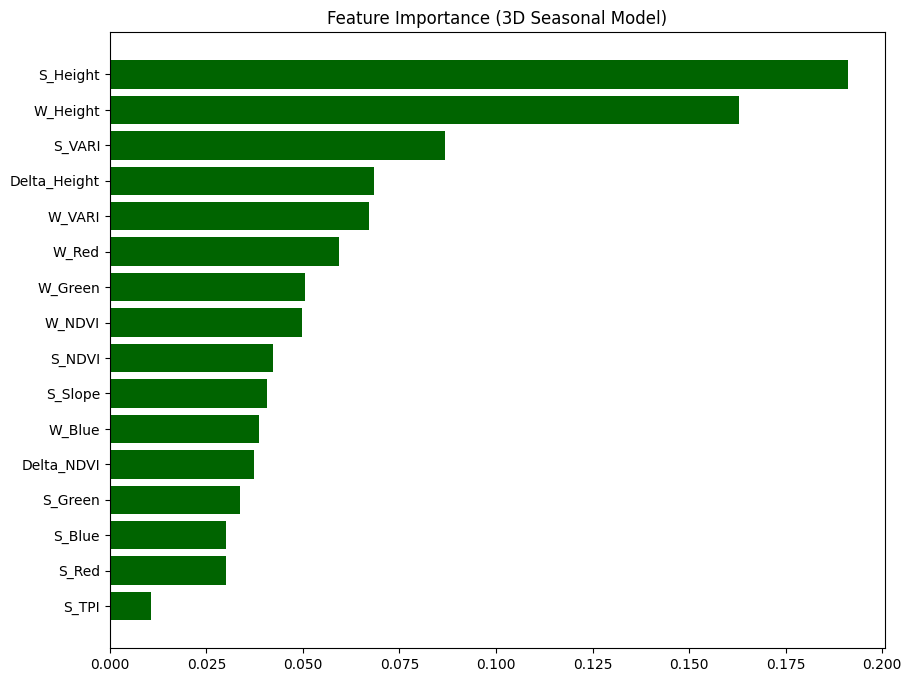

In [49]:
importances = rf.feature_importances_
feature_names = [
    'S_Red', 'S_Green', 'S_Blue', 'W_Red', 'W_Green', 'W_Blue',
    'S_NDVI', 'W_NDVI', 'S_VARI', 'W_VARI', 'Delta_NDVI',
    'S_Height', 'W_Height', 'Delta_Height',
    'S_Slope', 'S_TPI', 'Rel_Elev'
]
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance (3D Seasonal Model)')
plt.barh(range(len(indices)), importances[indices], color='darkgreen', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

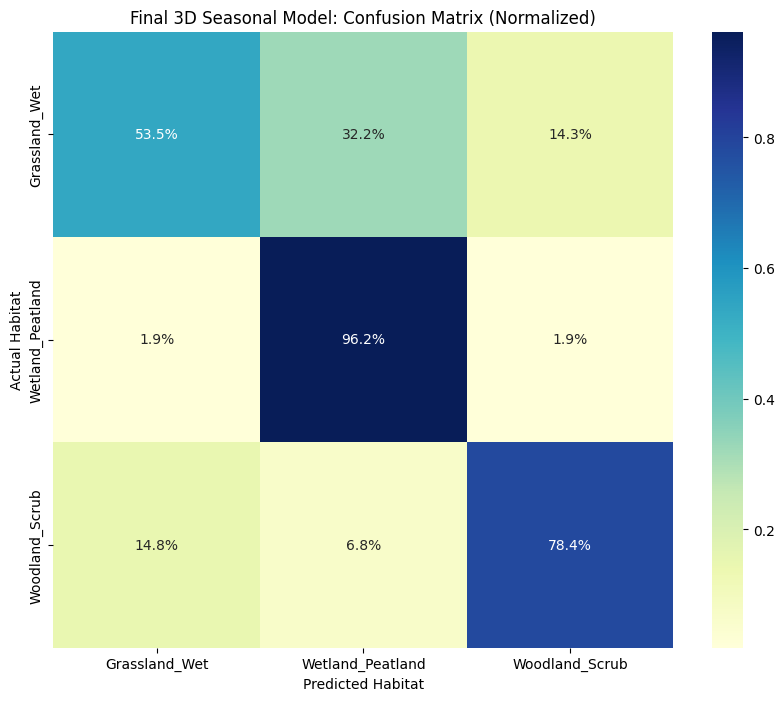

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

In [52]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd, \
     rasterio.open(W_RGB_PATH) as wr, rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['PRIMARY_FO'].replace(fossitt_merger)

    print("Extracting 32 Features (Seasonal + Height + Slope + Advanced Indices)...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 1000)
        if not pts: continue

        # 1. Base Sampling
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        w_rgb = np.array(list(wr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        w_nd  = np.array(list(wn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()
        w_h   = np.array(list(wd.sample(pts))).astype('float32').flatten()

        # 2. Slope Sampling
        s_slopes, w_slopes = [], []
        for pt in pts:
            r_idx, c_idx = sd.index(pt[0], pt[1])
            win = rasterio.windows.Window(c_idx - 1, r_idx - 1, 3, 3)
            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            w_win = wd.read(1, window=win, boundless=True, fill_value=0)
            s_slopes.append(calculate_local_slope(s_win, RES))
            w_slopes.append(calculate_local_slope(w_win, RES))

        # 3. Safe NIR Back-calculation
        # Clamp NDVI to [-0.99, 0.99] to prevent (1 - nd) becoming zero or negative
        s_nd_safe = np.clip(s_nd, -0.99, 0.99)
        w_nd_safe = np.clip(w_nd, -0.99, 0.99)

        s_nir = s_rgb[:, 0] * (1 + s_nd_safe) / (1 - s_nd_safe + 1e-5)
        w_nir = w_rgb[:, 0] * (1 + w_nd_safe) / (1 - w_nd_safe + 1e-5)

        # 4. Advanced Indices Calculation (Internal helper for safety)
        def calc_indices(r, g, b, nir):
            eps = 1e-5
            rvi = nir / (r + eps)
            savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
            evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
            gndvi = (nir - g) / (nir + g + eps)
            grvi = (g - r) / (g + r + eps)
            nrvi = (rvi - 1) / (rvi + 1 + eps)
            ndwi = (g - nir) / (g + nir + eps)
            vari = (g - r) / (g + r - b + eps)
            return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

        s_idx_stack = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)
        w_idx_stack = calc_indices(w_rgb[:,0], w_rgb[:,1], w_rgb[:,2], w_nir)

        # 5. Final Assembly (32 Features Total)
        combined = np.column_stack([
            s_rgb, w_rgb,          # 1-6
            s_nd, w_nd,            # 7-8
            s_h, w_h,              # 9-10
            s_nir, w_nir,          # 11-12
            s_idx_stack,           # 13-20 (8 summer indices)
            w_idx_stack,           # 21-28 (8 winter indices)
            s_slopes, w_slopes,    # 29-30
            (s_nd - w_nd),         # 31: Delta NDVI
            (s_h - w_h)            # 32: Delta Height
        ])

        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

# Stack and Clean for Random Forest
X = np.vstack(all_pixels)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.array(all_labels)

print(f"Extraction Complete: X shape is {X.shape}")

Extracting 32 Features (Seasonal + Height + Slope + Advanced Indices)...
Extraction Complete: X shape is (27091, 32)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [54]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [55]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 32-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 32-FEATURE REPORT ---
                  precision    recall  f1-score   support

             FS1       0.76      0.46      0.58      1035
             GA1       0.00      0.00      0.00         1
             GS4       0.68      0.68      0.68      1721
             PF1       0.72      0.88      0.79      3138
             WL2       0.74      0.30      0.42        88
             WN6       0.62      0.73      0.67       445
         WS1/WL2       0.58      0.39      0.47       296
Wetland_Peatland       0.66      0.61      0.63       804
  Woodland_Scrub       0.64      0.47      0.54       600

        accuracy                           0.69      8128
       macro avg       0.60      0.50      0.53      8128
    weighted avg       0.69      0.69      0.68      8128



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


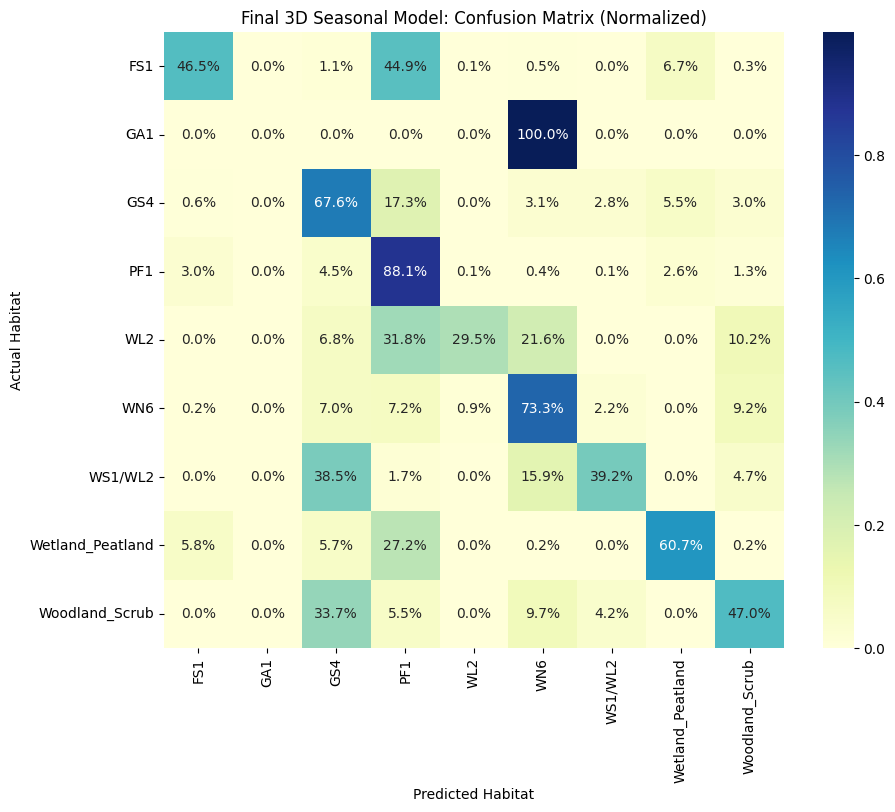

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

In [57]:
final_clean_map = {
    'FS1': 'Wetland_Peatland',
    'PF1': 'Wetland_Peatland',
    'Wetland_Peatland': 'Wetland_Peatland',
    'GS4': 'Grassland_Wet',
    'WN6': 'Woodland_Scrub',
    'WL2': 'Woodland_Scrub',
    'WS1/WL2': 'Woodland_Scrub',
    'Woodland_Scrub': 'Woodland_Scrub'
}

# Apply to your current y array
y_final_cleaned = np.array([final_clean_map.get(label, 'Other') for label in y])

# Filter out 'Other' if any exist
mask = y_final_cleaned != 'Other'
X_clean = X[mask]
y_clean = y_final_cleaned[mask]

# Re-split and Re-train
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, stratify=y_clean, random_state=42
)

rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- CLEANED 32-FEATURE REPORT ---")
print(classification_report(y_test, rf.predict(X_test)))


--- CLEANED 32-FEATURE REPORT ---
                  precision    recall  f1-score   support

   Grassland_Wet       0.74      0.58      0.65      1721
Wetland_Peatland       0.89      0.95      0.92      4976
  Woodland_Scrub       0.75      0.78      0.77      1430

        accuracy                           0.84      8127
       macro avg       0.80      0.77      0.78      8127
    weighted avg       0.84      0.84      0.84      8127



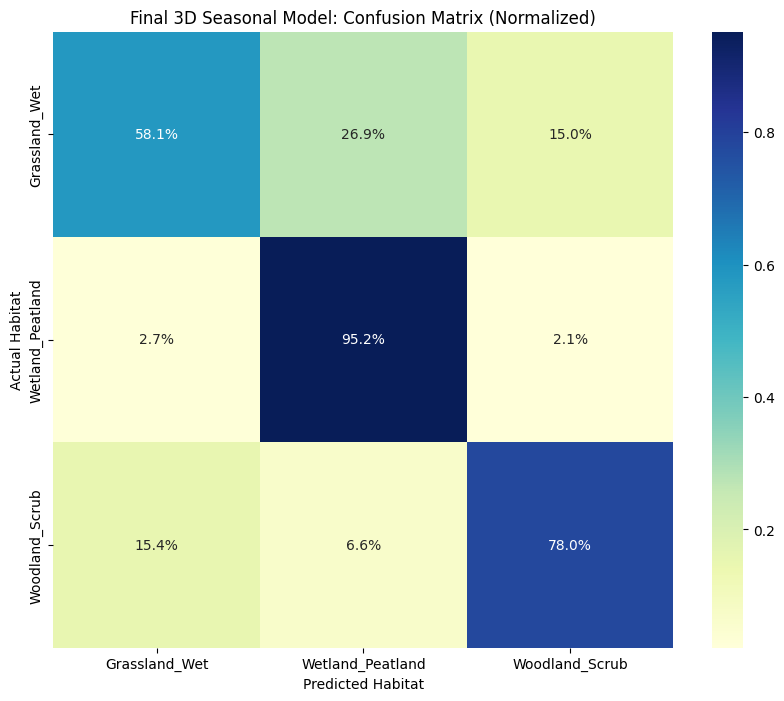

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()